# CNN - Convolutional Neural Network

Las Redes Neuronales Convolucionales (CNN) son una clase de redes neuronales diseñadas para el procesamiento eficiente de datos estructurados, especialmente imágenes. Con su capacidad para aprender automáticamente características jerárquicas y discriminativas, las CNN han revolucionado la visión por computadora, encontrando aplicaciones en la clasificación de imágenes, la detección de objetos y más allá.

Las CNN constan de dos partes principales: la extracción de características y la clasificación. En la etapa de extracción de características, las capas convolucionales y de agrupación (pooling) son responsables de detectar patrones significativos en los datos de entrada. Posteriormente, en la etapa de clasificación, las características extraídas se alimentan a capas totalmente conectadas que realizan la tarea de clasificación final.

<img src="img/cnn.png" width="800">


In [1]:
import tensorflow as tf
print(tf.__version__)

2024-05-03 18:21:31.612151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


In [19]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from matplotlib_inline.backend_inline import set_matplotlib_formats

# Cargar datos y dividirlos entre training y validation

In [20]:
df = pd.read_csv('./data/goemotions_clean.csv', sep=",")
df.head()

,text,emotion
0,Shhh dont give idea,anger
1,Thank much kind stranger I really need,gratitude
2,Ion know would better buy trim make hard dose,neutral
3,Im honestly surprised We fallen much farther,excitement
4,Jurisprudence fetishist get technicality,neutral


In [21]:
# Dividir el dataset en train y validation
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['emotion'], test_size=0.2, random_state=0)

In [22]:
np.round(len(X_train) / len(df), 2)

0.8

Comprobamos que la distribución de las clases es similar en train y validation

In [23]:
y_train.value_counts(normalize=True)

emotion
neutral           0.270155
approval          0.078017
annoyance         0.060092
admiration        0.058176
disapproval       0.053146
realization       0.036929
disappointment    0.035767
curiosity         0.034931
anger             0.034524
confusion         0.034106
amusement         0.033560
optimism          0.032248
gratitude         0.031702
joy               0.029402
love              0.025719
sadness           0.025556
caring            0.024453
surprise          0.022246
excitement        0.020991
disgust           0.020329
desire            0.015473
fear              0.011593
embarrassment     0.010885
Name: proportion, dtype: float64

In [24]:
y_val.value_counts(normalize=True)

emotion
neutral           0.269259
approval          0.079314
annoyance         0.062076
admiration        0.059428
disapproval       0.054921
realization       0.035777
amusement         0.035591
disappointment    0.034941
curiosity         0.034337
gratitude         0.033175
anger             0.032897
confusion         0.032153
optimism          0.030806
joy               0.028390
sadness           0.027274
love              0.026066
caring            0.023000
surprise          0.022860
disgust           0.022767
excitement        0.019236
desire            0.014915
fear              0.010594
embarrassment     0.010222
Name: proportion, dtype: float64

# Preprocesamiento de los datos

1. **Tokenización de Textos**:
   - **Tokenizador**: Usamos un objeto `Tokenizer` de Keras, que se inicializa para manejar un máximo de 5000 palabras distintas y emplea un token especial `<OOV>` para manejar palabras fuera del vocabulario (aquellas palabras que no se encuentran entre las 5000 más frecuentes).
   - **Fit del Tokenizador**: La función `fit_on_texts` se aplica a los datos de entrenamiento (`X_train`). Esto permite al tokenizador aprender el índice de todas las palabras presentes en el conjunto de entrenamiento. El tokenizador crea un mapeo de palabras a índices enteros, donde cada palabra única se asigna a un número entero único.

2. **Conversión de Textos a Secuencias**:
   - **Textos a Secuencias**: Convertimos los textos en secuencias de números enteros usando `texts_to_sequences`. Cada texto (una serie de palabras) se convierte en una serie de enteros, donde cada entero representa la palabra en el texto según el índice aprendido por el tokenizador.

3. **Padding de Secuencias**:
   - **Cálculo de la Longitud Máxima**: Calculamos la longitud de la secuencia más larga entre todos los textos de entrenamiento y prueba. Esto es necesario para estandarizar las longitudes de todas las secuencias, lo cual es un requisito para entrenar modelos de aprendizaje profundo.
   - **Aplicación de Padding**: Usando `pad_sequences`, estandarizamos la longitud de todas las secuencias. Las secuencias que son más cortas que la máxima longitud calculada se rellenan con ceros al final (padding 'post') para alcanzar la longitud estándar. Esto asegura que todas las entradas tengan la misma forma, lo cual es necesario para el procesamiento por la red neuronal.

4. **Resultados de la Función**:
   - La función devuelve las secuencias de entrenamiento y prueba ya rellenadas y estandarizadas, la longitud máxima de secuencia encontrada, y el tamaño total del vocabulario (el número de palabras únicas en el entrenamiento más uno para el token de padding).
   - También devuelve el objeto `tokenizer`, que puede ser útil para otras tareas de preprocesamiento o para inversión de las secuencias a texto si es necesario más adelante.

Este proceso de preprocesamiento es esencial para preparar los datos de texto para modelos que requieren entradas numéricas de longitud fija, como las CNNs, permitiendo que el modelo aprenda características importantes del texto mediante la estructura convolucional.

In [25]:
def tokenization(tokenizer: Tokenizer, X_train: pd.Series, X_test: pd.Series) -> tuple[np.ndarray, np.ndarray, int, int]:
    # Fit tokenizer on train set
    tokenizer.fit_on_texts(X_train)

    # Convert text to sequences for both train and test sets
    train_sequences = tokenizer.texts_to_sequences(X_train)
    test_sequences = tokenizer.texts_to_sequences(X_test)

    # Get length of the longest sequence
    max_seq_len = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))

    # Get vocabulary size
    vocab_size = len(tokenizer.word_index) + 1  # +1 for zero padding
    
    # Applying padding to both train and test sets
    train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding="post")
    test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

    return train_padded, test_padded, max_seq_len, vocab_size, tokenizer

In [26]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Obtain padded train and test sequences, length of longest sequence and vocabulary size
train_padded, val_padded, max_seq_len, vocab_size, tokenizer = tokenization(tokenizer, X_train, X_val)

# Construir el modelo

### Modelo Secuencial
El modelo es una instancia de `Sequential`, lo que significa que es una pila lineal de capas. Este es un tipo común de modelo en Keras que permite construir redes neuronales capa por capa en un orden secuencial.

### Capa de Embedding
La capa de `Embedding` es la primera capa del modelo, la cual transforma los índices enteros (que representan palabras en el texto) en vectores densos de un tamaño fijo (50). Este tamaño es un hiperparámetro que define la dimensión del espacio de embedding. La capa de embedding es crucial porque permite que el modelo maneje la entrada de texto con una representación más rica y significativa, capturando relaciones semánticas entre palabras.

### Capa Conv1D
La `Conv1D` es una capa que realiza una convolución unidimensional, ideal para datos secuenciales como el texto. Utiliza filtros (16) que se aplican a segmentos del texto para detectar patrones espaciales locales, como la presencia de ciertas palabras o frases. El `kernel_size` de 3 significa que el filtro cubre tres elementos de la secuencia a la vez, y `strides` de 1 indica que el filtro se mueve un elemento a la vez a través de la secuencia.

### Capa de MaxPooling1D
La capa `MaxPooling1D` reduce la dimensión de la entrada al tomar el valor máximo de las características detectadas en ventanas de tamaño 2 a lo largo de la dimensión temporal. Esto ayuda a hacer que las representaciones sean más manejables computacionalmente y más robustas a la posición de las características en el texto.

### Capas de Dropout
Las capas de `Dropout` con una tasa de 0.5 son una forma de regularización que ayuda a prevenir el sobreajuste al "apagar" aleatoriamente un subconjunto de características al entrenar el modelo. Esto obliga a que diferentes rutas en la red se activen en diferentes iteraciones, fomentando la redundancia y disminuyendo la dependencia del modelo en cualquier característica específica.

### Capa de Flatten
La capa `Flatten` convierte las matrices de características multidimensionales en un vector unidimensional, preparando el conjunto de características para pasar a través de capas densamente conectadas (Dense).

### Capas Densas
Luego siguen las capas `Dense`, que son capas totalmente conectadas. La primera tiene 32 unidades y utiliza la función de activación `relu` para introducir no linealidades en el modelo, lo que permite que el modelo aprenda patrones más complejos.

### Capa de Salida
Finalmente, la capa de salida tiene 24 unidades con una función de activación `softmax`, que es adecuada para la clasificación multiclase porque convierte las salidas del modelo en probabilidades de clase. La suma de todas las probabilidades de salida será 1, y cada neurona de salida representará la probabilidad de que la entrada pertenezca a una de las 24 clases.

### Compilación del Modelo
El modelo se compila con la función de pérdida `categorical_crossentropy`, que es adecuada para problemas de clasificación multiclase, y el optimizador `adam`, que es un algoritmo de optimización popular debido a su eficacia en diferentes tipos de redes neuronales. La métrica `accuracy` se usa para monitorear el rendimiento del modelo durante el entrenamiento y la evaluación.

In [27]:
model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_seq_len))

# Convolutional layer
model.add(Conv1D(filters=16, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Flatten and classifier
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))

# Output layer
model.add(Dense(24, activation="softmax"))

In [28]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

## Entrenar modelo

In [29]:
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

In [30]:
model_path = os.path.join(models_dir, "cnn_model.keras")

El `ModelCheckpoint` guarda automáticamente el mejor modelo mientras entrena, así que siempre tienes la versión que mejor desempeño tuvo en el proceso de validación.

In [31]:
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [32]:
all_possible_labels = np.unique(np.concatenate((y_train, y_val)))  # Recolecta todas las etiquetas únicas

label_encoder = LabelEncoder()
label_encoder.fit(np.append(all_possible_labels, 'desconocido'))  # Agrega 'desconocido' al final

# Transformar las etiquetas de entrenamiento directamente
y_train_encoded = label_encoder.transform(y_train)

# Verificar y reemplazar las etiquetas desconocidas en validación
y_val_safe = np.where(np.isin(y_val, label_encoder.classes_), y_val, 'desconocido')
y_val_encoded = label_encoder.transform(y_val_safe)

In [33]:
num_classes = len(label_encoder.classes_)

y_train_encoded = to_categorical(y_train_encoded, num_classes)
y_val_encoded = to_categorical(y_val_encoded, num_classes)

In [34]:
print("train_padded shape:", train_padded.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("val_padded shape:", val_padded.shape)
print("y_val_encoded shape:", y_val_encoded.shape)

train_padded shape: (86084, 19)
y_train_encoded shape: (86084, 24)
val_padded shape: (21522, 19)
y_val_encoded shape: (21522, 24)


In [35]:
history = model.fit(
    train_padded, y_train_encoded,
    epochs=20,
    batch_size=64,
    shuffle=True,
    validation_data=(val_padded, y_val_encoded),
    callbacks=[mc]
)

Epoch 1/20


1345/1346 [============================>.] - ETA: 0s - loss: 2.7677 - acc: 0.2688
Epoch 1: val_loss improved from inf to 2.65097, saving model to ./models/cnn_model.keras
1346/1346 [==============================] - 44s 32ms/step - loss: 2.7677 - acc: 0.2688 - val_loss: 2.6510 - val_acc: 0.2855
Epoch 2/20
1345/1346 [============================>.] - ETA: 0s - loss: 2.6332 - acc: 0.2855
Epoch 2: val_loss improved from 2.65097 to 2.53851, saving model to ./models/cnn_model.keras
1346/1346 [==============================] - 41s 30ms/step - loss: 2.6332 - acc: 0.2855 - val_loss: 2.5385 - val_acc: 0.2999
Epoch 3/20
1345/1346 [============================>.] - ETA: 0s - loss: 2.5385 - acc: 0.2929
Epoch 3: val_loss improved from 2.53851 to 2.49994, saving model to ./models/cnn_model.keras
1346/1346 [==============================] - 42s 31ms/step - loss: 2.5385 - acc: 0.2929 - val_loss: 2.4999 - val_acc: 0.2951
Epoch 4/20
1345/1346 [============================>.] - ETA: 0s - loss: 2.4817 - a

In [36]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 50)            1377350   
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 16)            2416      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 9, 16)             0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 9, 16)             0         
                                                                 
 flatten_1 (Flatten)         (None, 144)               0         
                                                                 
 dropout_3 (Dropout)         (None, 144)               0         
                                                      

In [37]:
def plot_metric_curves(epochs, train_curve, val_curve, train_color, val_color, metric, epochs_interval: int = 1):
    # Set graphics format as svg
    set_matplotlib_formats('svg')
    # Add grid
    sns.set_style("whitegrid")
    # Set figure size
    plt.figure(figsize=(12,8), dpi=200)
    # Plot curves
    plt.plot(epochs, train_curve, color=train_color, linewidth=2, label=f'Training {metric.lower()}')
    plt.plot(epochs, val_curve, color=val_color, linewidth=2, label=f'Validation {metric.lower()}')
    # Set title and labels
    plt.title(f'Training and validation {metric.lower()}', fontsize=20)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel(metric.capitalize(), fontsize=15)
    # Show epoch values in x-axis in the specified interval
    plt.xticks(epochs[::epochs_interval])
    # Set max x-axis as the last epoch + 1
    plt.xlim(0, epochs[-1] + 1)
    # Remove top and right spines
    sns.despine(left=True, bottom=True)
    # Put the legend outside of the plot
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)
    plt.show()
    return

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

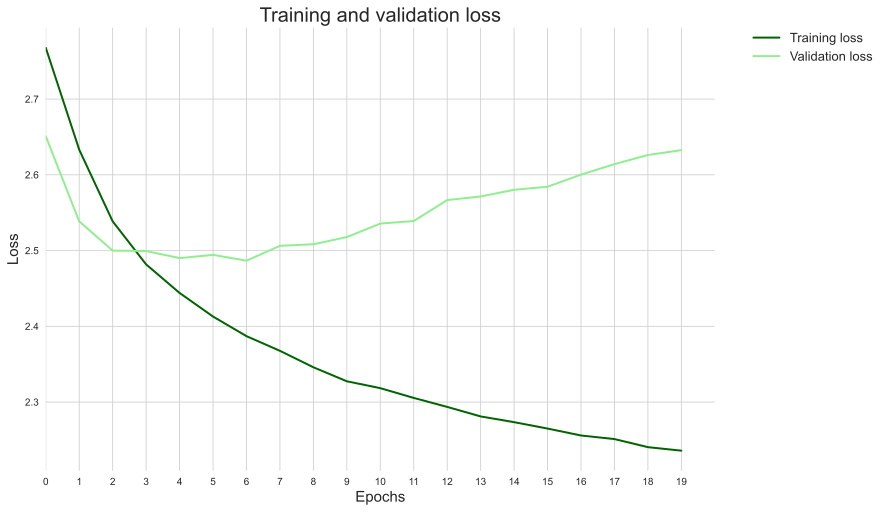

In [39]:
plot_metric_curves(epochs, loss, val_loss, "darkgreen", "lightgreen", "Loss", 1)

En esta gráfica se puede ver que la pérdida de entrenamiento disminuye constantemente, lo cual es bueno ya que indica que el modelo está aprendiendo y mejorando en la tarea de predecir los datos de entrenamiento. Sin embargo, la pérdida de validación, después de disminuir inicialmente, comienza a aumentar después de aproximadamente 5 epochs. Esto sugiere que el modelo puede estar comenzando a sobreajustarse a los datos de entrenamiento (overfitting), ya que su rendimiento en los datos no vistos (validación) empeora.

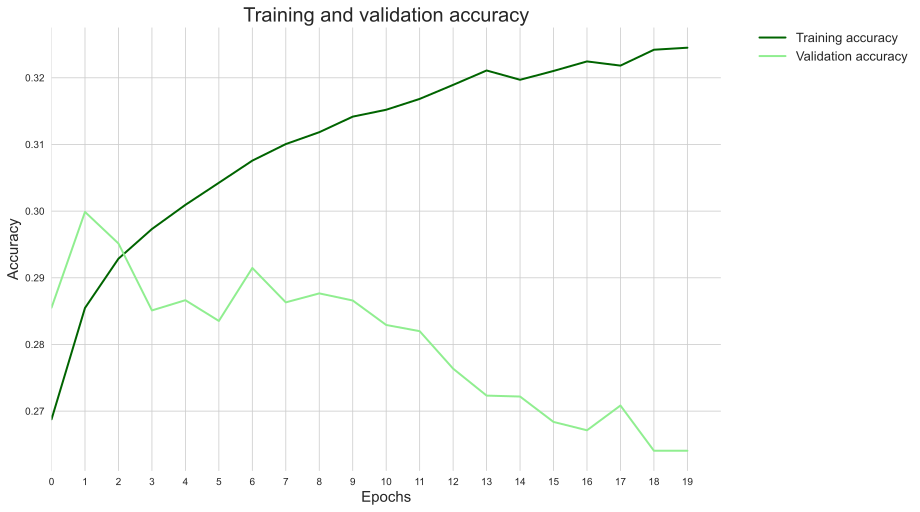

In [40]:
plot_metric_curves(epochs, acc, val_acc, "darkgreen", "lightgreen", "Accuracy", 1)

Esta gráfica muestra que la precisión de entrenamiento mejora de manera constante, lo cual es lo que esperaríamos durante el proceso de entrenamiento. No obstante, la precisión de validación es muy fluctuante y tiende a disminuir después de aproximadamente 5 epochs, lo que también sugiere sobreajuste. La discrepancia entre la precisión de entrenamiento y de validación es un signo claro de que el modelo no está generalizando bien a nuevos datos.

# Predicciones

In [41]:
# Predecir las emociones en el conjunto de validación
y_pred_probs = model.predict(val_padded)
y_val_label_encoded = np.argmax(y_val_encoded, axis=1)
y_val_labels = label_encoder.inverse_transform(y_val_label_encoded)


emotion_labels = label_encoder.classes_

673/673 [==============================] - 2s 3ms/step


In [42]:
emotion_to_emoji = {
    'admiration': '🤩',
    'amusement': '😄',
    'anger': '😡',
    'annoyance': '😑',
    'approval': '👍',
    'caring': '🥰',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😏',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤢',
    'embarrassment': '😳',
    'excitement': '😃',
    'fear': '😨',
    'gratitude': '🙏',
    'joy': '😀',
    'love': '❤️',
    'neutral': '😐',
    'optimism': '😊',
    'realization': '😲',
    'sadness': '😢',
    'surprise': '😮'
}

In [43]:
# Dataframe con texto, emoción real y top 3 de emociones predichas con sus probabilidades
df_results = pd.DataFrame(columns=['text', 'top1', 'top2', 'top3'])
df_results['text'] = X_val

# Obtener las etiquetas de las emociones predichas
top1_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -1]]
top2_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -2]]
top3_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -3]]

# Mapear las emociones a emojis
top1_labels = [emotion_to_emoji[label] for label in top1_labels]
top2_labels = [emotion_to_emoji[label] for label in top2_labels]
top3_labels = [emotion_to_emoji[label] for label in top3_labels]

# Obtener las probabilidades de las emociones predichas
top1_probs = y_pred_probs.max(axis=1) * 100  # Multiplicar por 100 para obtener el porcentaje
top2_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -2]] * 100
top3_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -3]] * 100

# Asignar valores al DataFrame
df_results['top1'] = [f'{label} {prob:.0f}%' for label, prob in zip(top1_labels, top1_probs)]
df_results['top2'] = [f'{label} {prob:.0f}%' for label, prob in zip(top2_labels, top2_probs)]
df_results['top3'] = [f'{label} {prob:.0f}%' for label, prob in zip(top3_labels, top3_probs)]

# Resetear el índice
df_results.reset_index(drop=True, inplace=True)

df_results.head()


,text,top1,top2,top3
0,Maybe could put context wa responding someone ...,😐 39%,😑 11%,👎 10%
1,NAME like picking choosing life work fact work,😐 32%,👍 12%,😲 7%
2,How people eat paper plate theyre bbq,😐 47%,👎 10%,😑 10%
3,Thank voice reason people keep screaming Vatic...,😐 13%,🤩 12%,😮 8%
4,Gotta love trailing minute,❤️ 26%,😀 17%,🤩 16%
